# ch4

## imports

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

SEED=42
np.random.seed(42)

## Linear Regression

[[4.21509616]
 [2.77011339]]


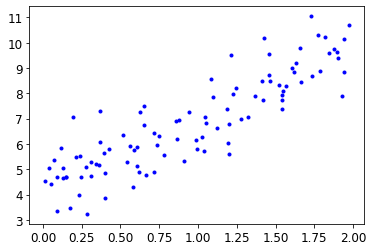

In [2]:
# y = 4+3x +gaussian blur
X = 2*np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
plt.plot(X,y,".b")

# find theta_hat
X_b = np.c_[np.ones((100,1)),X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best)

[[4.21509616]
 [9.75532293]]


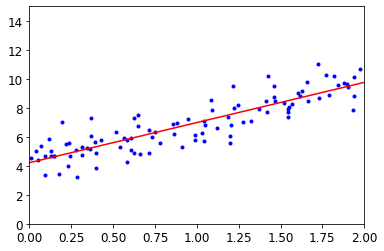

In [3]:
# predict y and line
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_pred = X_new_b.dot(theta_best)
print(y_pred)
plt.axis([0,2,0,15]) # set window??
plt.plot(X,y,"b.")
plt.plot(X_new,y_pred,"r-")

In [4]:
# linear regression with sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

# np.linalg.pinv(X_b).dot(y) # 이렇게도 ㄱㄴ
# https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse#Singular_value_decomposition_(SVD)

[4.21509616] [[2.77011339]]
[[4.21509616]
 [9.75532293]]


## Gradient Descent

In [5]:
# raw implementation

eta = 0.1 # learning rate
n_iterations = 1000
m = 1000
theta = np.random.randn(2,1)

for i in range(m+1):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
print(list(theta))

[array([4.15828724]), array([2.82027257])]


In [6]:
## sgdm

n_epochs = 50
t0,t1 = 5,50
theta = np.random.randn(2,1)

def learning_schedule(t): 
    return t0/(t+t1)

for epoch in range(n_epochs):
    for i in range(m):
        idx = np.random.randint(m)
        xi = X_b[idx:idx+1]
        yi = y[idx:idx+1]
        gradients = 2* xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta - eta * gradients
print(list(theta)) # why answer random??? 3.xxxx

[array([3.58179619]), array([3.33709681])]


In [7]:
# with sklearn
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=100, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[4.20011322] [2.75690565]


## Polynomial Regression

In [8]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [9]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0],X_poly[0])

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[0.7546826] [0.7546826  0.56954582]
[2.16094478] [[0.99975622 0.48439572]]


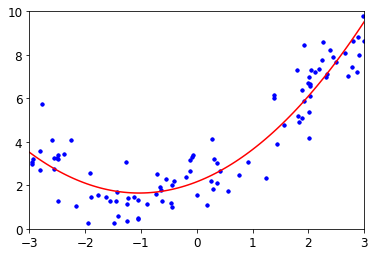

In [10]:
m = 100
plt.axis([-3,3,0,10])
# plt.plot(X_new, y_new, "b.")
plt.plot(X, y, "b.")

X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X,y,"b.")
plt.plot(X_new,y_new,"r-")

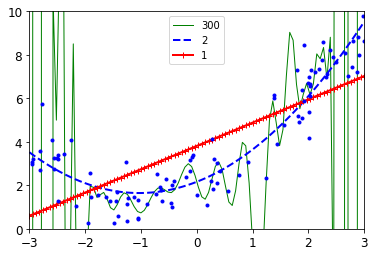

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style,linewidth,deg in [("g-",1,300),("b--",2,2),("r-+",2,1)]:
    feats = PolynomialFeatures(degree=deg, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomiial_regression = Pipeline([
        ("features",feats),
        ("std_scaler",std_scaler),
        ("lin_reg",lin_reg)
    ])
    polynomiial_regression.fit(X,y)
    y_newbig = polynomiial_regression.predict(X_new)
    plt.plot(X_new,y_newbig,style,label=str(deg),linewidth=linewidth)
plt.plot(X,y,"b.",linewidth=3)
plt.legend()
plt.axis([-3, 3, 0, 10])
plt.show()

# degree=1: undefit
# degree=300: overfit

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = \
        train_test_split(X,y,test_size=0.2, random_state=SEED)
    
    train_errors, val_errors = [],[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_pred_train = model.predict(X_train[:m])
        y_pred_val = model.predict(X_val)
        train_errors.append(mse(y_train[:m],y_pred_train,squared=False))
        val_errors.append(mse(y_val,y_pred_val,squared=False))

    # plot errors
    plt.plot(train_errors,label="train")
    plt.plot(val_errors,label="val")
    plt.legend()

(0.0, 80.0, 0.0, 3.0)

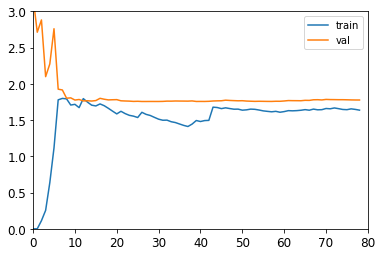

In [13]:
# linear regression learning curve
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])

(0.0, 80.0, 0.0, 3.0)

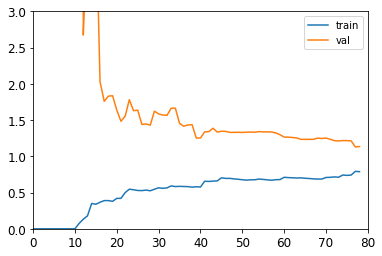

In [14]:
# polynomial regression learning curve
polynomial_regression = Pipeline([
    ("features",PolynomialFeatures(degree=10,include_bias=False)),
    ("lin_reg",LinearRegression())
])
plot_learning_curves(polynomial_regression,X,y)
plt.axis([0, 80, 0, 3])

## Linear model with restriction

In [15]:
# data
np.random.seed(SEED)
m = 20
X = 3*np.random.rand(m,1)
y = 1+0.5*X+np.random.randn(m,1)/1.5
X_new = np.linspace(0,3,100).reshape(100,1)

### Ridge

In [16]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=SEED)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [17]:
sgd_reg = SGDRegressor(penalty="l2",random_state=SEED)
# or Ridge(alpha=1, solver="sag", random_state=SEED)
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### Lasso

In [18]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
# or SGDRegressor(penalty="l1")
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### Elastic net

In [19]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
print(elastic_net.predict([[1.5]]))

elastic_net = ElasticNet(alpha=0.1, l1_ratio=1)
elastic_net.fit(X,y)
print(elastic_net.predict([[1.5]]))

[1.54333232]
[1.53788174]


### Early stopping

In [20]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = \
    train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [21]:
from sklearn.base import clone

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90,include_bias=False)),
    ("std_scaler",StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val) # not fit_transform

sgd_reg = SGDRegressor(max_iter=1, tol=-np.inf, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005,
                       random_state=SEED)

minimum_val_error = np.inf
best_epoch, best_model = None,None
n_epochs = 500
train_errors, val_errors = [],[]

for epoch in range(n_epochs):
    # fit and predict
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_pred = sgd_reg.predict(X_train_poly_scaled)
    y_val_pred = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mse(y_train,y_train_pred,squared=False))
    val_errors.append(mse(y_val,y_val_pred,squared=False))
    
    # # update
    rmse = mse(y_val,y_val_pred,squared=False)
    if rmse < minimum_val_error:
        minimum_val_error = rmse
        best_epoch = epoch
        best_model = clone(sgd_reg)

print(min(train_errors), min(val_errors))
print(best_model)
print(best_epoch)

0.7329987063929957 1.1624590535779686
SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             random_state=42, tol=-inf, warm_start=True)
239


Text(239, 2.078173944026644, 'Best model')

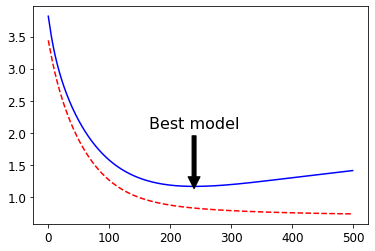

In [22]:
plt.plot(val_errors,"b-")
plt.plot(train_errors,"r--")

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

## Logistic Regression

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris.keys())
print(iris.DESCR)
X = iris["data"][:,3:]
y = (iris["target"]==2).astype(int) # 1=virginica, 0=not virginica

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    peta

In [24]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs",random_state=SEED)
log_reg.fit(X,y)
print(log_reg.predict([[1.7],[1.5]]))

[1 0]


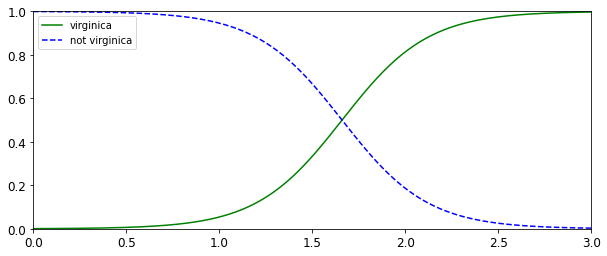

In [25]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.figure(figsize=(10,4))
plt.axis([0,3,0,1])
plt.plot(X_new, y_proba[:,1],"g-",label="virginica")
plt.plot(X_new, y_proba[:,0],"b--",label="not virginica")
plt.legend()

### Softmax Regression

In [26]:
iris = load_iris()
X = iris["data"][:,(2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

print(softmax_reg.predict([[5,2]]))
print(softmax_reg.predict_proba([[5,2]]))
# sentosa, versicolor, virginica

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]
